<a href="https://colab.research.google.com/github/venkatachandrasekhar/Visual-Search/blob/main/VisualSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
import keras
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import GlobalAveragePooling2D

import cv2
import numpy as np
from numpy.linalg import norm
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

from sklearn.neighbors import NearestNeighbors

import pickle

In [ ]:
model = ResNet50(weights= 'imagenet', include_top= False, input_shape=(224,224,3))
model.trainable = False
model = keras.Sequential([model, GlobalAveragePooling2D()])

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


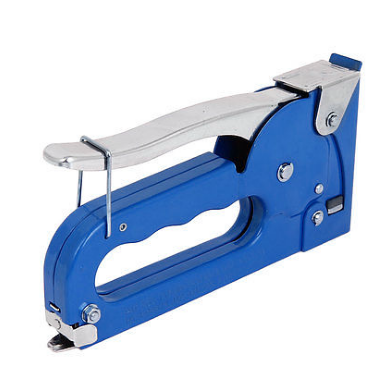

In [ ]:
img = cv2.imread('/content/Dataset/391220951985_0.JPG')
plt.imshow(img)
plt.axis("off")
plt.show()
# img = cv2.resize(img, (224,224))
# print(cv2_imshow(img))
# img = np.array(img)
# print(img)
# img = np.expand_dims(img, axis=0)
# img = preprocess_input(img)
# print(img)
# result = model.predict(img)
# result = result.flatten()
# result = result/norm(result)


In [ ]:
def vector_extraction(img_path, model) :
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224,224))
  img = np.array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  result = model.predict(img)
  result = result.flatten()
  result = result/norm(result)
  return result

In [ ]:
result = vector_extraction('/content/Dataset/381070404735_7.JPG', model)
result

1/1 [==============================] - 2s 2s/step


array([8.8398745e-03, 6.6100894e-03, 8.0814098e-06, ..., 2.4913801e-03,
       2.3539239e-04, 3.3221204e-02], dtype=float32)

In [ ]:
# import os
# folder_name = []
# for foldername in os.listdir('C:\\Users\\svchandra\\Downloads\\archive\\Stanford_Online_Products\\'):
#   folder_name.append(os.path.join('C:\\Users\\svchandra\\Downloads\\archive\\Stanford_Online_Products\\', foldername))

# folder_name

In [ ]:
import os
file_names = []
vector_lst = []
for filename in os.listdir('/content/Dataset'):
  file_names.append(os.path.join('/content/Dataset', filename))
  vector_lst.append(vector_extraction(os.path.join('/content/Dataset', filename), model))

1/1 [==============================] - 0s 190ms/step


In [ ]:
print(len(file_names))
print(len(vector_lst))

160
160


In [ ]:
with open('vectors_lst.pkl', 'wb') as file:
	pickle.dump(vector_lst, file)

with open('file_names.pkl', 'wb') as file:
	pickle.dump(file_names, file)

In [ ]:
neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
neighbors.fit(vector_lst)
img_path = '/content/Dataset/391220951985_0.JPG'
img = cv2.imread(img_path)
img = cv2.resize(img, (224,224))
img = np.array(img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)
result = model.predict(img)
result = result.flatten()
result = result/norm(result)

distances, indices = neighbors.kneighbors([result])

1/1 [==============================] - 0s 283ms/step


In [ ]:
file_names[indices[0][0]]

'/content/Dataset/391220951985_0.JPG'

In [ ]:
from matplotlib import pyplot as plt
for file in indices[0][:]:
  img_color = cv2.imread(file_names[file])
  plt.imshow(img_color)
  plt.axis("off")
  plt.show()

In [ ]:
!pip install flask-ngrok
!pip install flask
!pip install scikit-learn

In [ ]:
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok
import os
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from werkzeug.utils import secure_filename

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when the app is run

app.config['UPLOAD_FOLDER'] = '/content/uploads'
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

# Load the precomputed vectors
with open('/content/vectors_lst.pkl', 'rb') as f:
    vectors = pickle.load(f)

# Load the precomputed file names
with open('/content/file_names.pkl', 'rb') as f:
    file_names = pickle.load(f)

# Dummy function to convert image to vector
# Replace with your actual model inference code
def image_to_vector(image_path):
  img = cv2.imread(image_path)
  img = cv2.resize(img, (224,224))
  img = np.array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  result = model.predict(img)
  result = result.flatten()
  result = result/norm(result)
  neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
  neighbors.fit(vectors)
  distances, indices = neighbors.kneighbors([result])
  return distances, indices


@app.route('/')
def index():
    return '''
    <h1>Visual Search</h1>
    <form action="/upload" method="post" enctype="multipart/form-data">
        <input type="file" name="file">
        <input type="submit" value="Upload">
    </form>
    '''

@app.route('/upload', methods=['POST'])
def upload_image():
    if 'file' not in request.files:
        return 'No file part'
    file = request.files['file']
    if file.filename == '':
        return 'No selected file'
    if file:
        filename = secure_filename(file.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)

        # Convert the uploaded image to vector
        distances, indices = image_to_vector(file_path)


        result_html = '<h2>Uploaded Image:</h2>'
        result_html += f'<img src="{file_path}" style="max-width: 300px;">'

        result_html += '<h2>Similar Images:</h2>'
        for img in indices[0][:]:
            result_html += f'<img src="{file_names[img]}" style="max-width: 150px;">'

        return result_html

if __name__ == '__main__':
    app.run()


In [ ]:
# Save the app.py file
with open('app.py', 'w') as f:
    f.write("""from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok
import os
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from werkzeug.utils import secure_filename

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when the app is run

app.config['UPLOAD_FOLDER'] = '/content/uploads'
os.makedirs(app.config['UPLOAD_FOLDER'], exist_ok=True)

# Load the precomputed vectors
with open('/content/vectors_lst.pkl', 'rb') as f:
    vectors = pickle.load(f)

# Load the precomputed file names
with open('/content/file_names.pkl', 'rb') as f:
    file_names = pickle.load(f)

# Dummy function to convert image to vector
# Replace with your actual model inference code
def image_to_vector(image_path):
  img = cv2.imread(image_path)
  img = cv2.resize(img, (224,224))
  img = np.array(img)
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  result = model.predict(img)
  result = result.flatten()
  result = result/norm(result)
  neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean')
  neighbors.fit(vectors)
  distances, indices = neighbors.kneighbors([result])
  return distances, indices


@app.route('/')
def index():
    return '''
    <h1>Visual Search</h1>
    <form action="/upload" method="post" enctype="multipart/form-data">
        <input type="file" name="file">
        <input type="submit" value="Upload">
    </form>
    '''

@app.route('/upload', methods=['POST'])
def upload_image():
    if 'file' not in request.files:
        return 'No file part'
    file = request.files['file']
    if file.filename == '':
        return 'No selected file'
    if file:
        filename = secure_filename(file.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)

        # Convert the uploaded image to vector
        distances, indices = image_to_vector(file_path)


        result_html = '<h2>Uploaded Image:</h2>'
        result_html += f'<img src="{file_path}" style="max-width: 300px;">'

        result_html += '<h2>Similar Images:</h2>'
        for img in indices[0][:]:
            result_html += f'<img src="{file_names[img]}" style="max-width: 150px;">'

        return result_html

if __name__ == '__main__':
    app.run()""")

# Upload your model.pkl file to /content
# You can use the file upload feature in Colab to do this

# Run the Flask app
!python app.py


 * Serving Flask app 'app'
 * Debug mode: off
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
Usage of ngrok requires a verified account and authtoken.

Sign up for an account: https://dashboard.ngrok.com/signup
Install your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken

ERR_NGROK_4018

Exception in thread Thread-1:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.p